# CICY4:CNN-GRU hybrid for 4 Hodge numbers

- V1: Use ReduceLROnPlateau with GRU block (20, 64, 6, 4), train loss ~ 9.0
- V2: Use OneCycleLR: train loss ~ 900 (bad result)
- V3 Use CosineAnnealingLR: train loss ~ 60 (bad result)
- V4: Use ReduceLROnPlateau again, but with higher max LR (bad result)
- V5/V6: Change the GRU block architecture to have fewer layers, but with larger size for the hidden layer (100 -> 128), increase the size of the dense layers. Use ReduceLROnPlateau with max learning rate of 0.1, min LR of 1e-6. Very good result obtained: (81, 69, 48, 13) accuracy for (h11, h21, h31, h22). Train loss ~ 3.0, test loss ~ 6.0
- V7/V8: Increase the hidden size of the GRU block from 128->256 and reduce the num_layer from 4-> 2. Same learning parameters as V5. (84, 74, 52, 19)
- V9: Change the CNN block to have filters [128,128,64], GRU block is (20,256,1,4)
- V10: Use the same architecture as V8, with more complex dense layers: 1 more layers  (with Relu activation)

For GRU block, the standalone best model so far has the parameters (in_channels, hidden_size, num_layers, outputs) =  (20, 64, 6, 4). 

In [1]:
import numpy as np
import os as os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
sns.set_style("darkgrid")

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# load data
path = '/kaggle/input/calabi-yau-cicy-4-folds/'

conf = np.load('/kaggle/input/calabi-yau-cicy-4-folds/conf.npy')
hodge = np.load(os.path.join(path, 'hodge.npy'))
direct = np.load(os.path.join(path, 'direct.npy'))
conf.shape, hodge.shape, direct.shape

((921497, 16, 20), (921497, 4), (921497,))

In [3]:
if not os.path.exists('saved_models'):
    os.makedirs('saved_models')

In [4]:
import sys
sys.path.append('/kaggle/input/calabi-yau-cicy-4-folds')
from CICY4_functions import data_generator, batch_gd_scheduler,  calc_accuracy_mr, plot_losses

In [5]:
from sklearn.model_selection import train_test_split

def train_test(X, y):
    X_train,  X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101, shuffle = True)
    
    X_train = torch.from_numpy(X_train.astype(np.float32))
    #only need reshape if the y dimension is 1
    #y_train = torch.from_numpy(y_train.astype(np.float32).reshape(-1, 1))
    y_train = torch.from_numpy(y_train.astype(np.float32))

    X_test = torch.from_numpy(X_test.astype(np.float32))
    #y_test = torch.from_numpy(y_test.astype(np.float32).reshape(-1, 1))
    y_test = torch.from_numpy(y_test.astype(np.float32))                         
    
    print(f'X_train shape: {X_train.shape}, \n y_train shape:{y_train.shape},\
                 \n X_test shape: {X_test.shape}, \n y_test shape:{y_test.shape}')
    return X_train, X_test, y_train, y_test

In [6]:
X = conf
y = hodge

X_train, X_test, y_train, y_test = train_test(X, y)

train_gen = lambda: data_generator(X_train, y_train)
test_gen = lambda: data_generator(X_test, y_test)

X_train shape: torch.Size([737197, 16, 20]), 
 y_train shape:torch.Size([737197, 4]),                 
 X_test shape: torch.Size([184300, 16, 20]), 
 y_test shape:torch.Size([184300, 4])


In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# CNN-RNN hybrid

In [8]:
##################### CNN ###############################
class CNN_block(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,128, 4, 1)
        #self.bn1 = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(128, 64, 3, 1)
        #self.bn2 = nn.BatchNorm2d(64)
        self.mxpool = nn.MaxPool2d(2,2)
        #self.conv3 = nn.Conv2d(128,64, 2, 1)
        self.flat = nn.Flatten()
        self.conv_total = nn.Sequential(
            self.conv1,
            #self.bn1,
            self.mxpool,
            #self.bn2,
            self.conv2,
            self.mxpool,
            #self.conv3,
        )

    def forward(self,x):
        x = F.relu(self.conv_total(x))
        #reshape is the same as flat(x)
        #x = x.reshape(x.shape[0], -1)
        x = self.flat(x)
        
        return x

In [9]:
cnn_block = CNN_block()
cnn_block.to(device)

CNN_block(
  (conv1): Conv2d(1, 128, kernel_size=(4, 4), stride=(1, 1))
  (conv2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
  (mxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (conv_total): Sequential(
    (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)

In [10]:
class RNN_block(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
        super(RNN_block,self).__init__()
        self.D = n_inputs
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers        
        #self.lstm = nn.LSTM(input_size = self.D,
        #                   hidden_size = self.M,
        #                   num_layers = self.L,
        #                   batch_first = True)    
        self.gru = nn.GRU(input_size = self.D,
                           hidden_size = self.M,
                           num_layers = self.L,
                           batch_first = True)
        #self.fc1 = nn.Linear(self.M, 128)
        #self.fc2 = nn.Linear(128, self.K)
    def forward(self, X):
        #input X is NxTxD
        #initial hidden states
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        #c0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        #get LSTM unit output:
        #output is NxTxM
        #out, _ = self.lstm(X, (h0,c0))
        out, _ = self.gru(X, h0)   
        #we only want h(T) at the final time step
        # output is now of shape (N, M)
        out = out[:, -1, :]

        return out

In [11]:
#gru_block = RNN_block(20, 64, 6, 4)
#gru_block = RNN_block(20, 128, 4, 4)
gru_block = RNN_block(20, 256, 2, 4)
gru_block.to(device)

RNN_block(
  (gru): GRU(20, 256, num_layers=2, batch_first=True)
)

In [12]:
class CNN_RNN_hybrid(nn.Module):
    def __init__(self, cnn_block, rnn_block, feat_vec_size):
        super(CNN_RNN_hybrid, self).__init__()
        self.cnn_block = cnn_block
        self.rnn_block = rnn_block
        self.feat_vec_size = feat_vec_size
        self.fc1 = nn.Linear(self.feat_vec_size, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 4)
        
    def forward(self, x):
        #output of cnn block is (N,384)
        x1 = x.view(-1,1, 16,20)
        x1 = self.cnn_block(x1)
        #output of rnn block is (N,M = 64)
        x2 = self.rnn_block(x)
        #concatenate the 2 outputs to produce a feat vec (N, M+384)
        xx = torch.cat([x1, x2], dim = 1)
        # pass through linear layers
        xx = F.relu(self.fc1(xx))
        xx = F.relu(self.fc2(xx))
        #final output is 4
        xx = self.fc3(xx)
        
        return xx

In [13]:
model = CNN_RNN_hybrid(cnn_block, gru_block, 256+384)
model.to(device)

CNN_RNN_hybrid(
  (cnn_block): CNN_block(
    (conv1): Conv2d(1, 128, kernel_size=(4, 4), stride=(1, 1))
    (conv2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
    (mxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (flat): Flatten(start_dim=1, end_dim=-1)
    (conv_total): Sequential(
      (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(1, 1))
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (rnn_block): RNN_block(
    (gru): GRU(20, 256, num_layers=2, batch_first=True)
  )
  (fc1): Linear(in_features=640, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=4, bias=True)
)

In [14]:
#count the number of parameters in the model
params = [p.numel() for p in model.parameters() if p.requires_grad]
print(sum(params))

1867460


# Shape Tracing

In [15]:
X = X_train[0].to(device)
y = y_train[0].to(device)
print('RNN BLOCK SHAPE TRACING')
print(f'Original shape of the image before passing through the network: \n {X.shape}\n')

print('Reshape the size to take in account the batch number')
X = X.view(1,16,20)
print(f'The new size is {X.shape}\n')

h0 = torch.zeros(gru_block.L, X.size(0), gru_block.M).to(device)
#c0 = torch.zeros(gru_block.L, X.size(0), gru_block.M).to(device)
X, _ = gru_block.gru(X, h0)
print(f'Shape of the image after passing through the {gru_block.gru}: \n {X.shape}\n')

#get only the h(T) at the last time step
Xg = X[:, -1, :]
print(f'The final output shape is {Xg.shape}')
#print(X)
#print(f'Target: {y}')

RNN BLOCK SHAPE TRACING
Original shape of the image before passing through the network: 
 torch.Size([16, 20])

Reshape the size to take in account the batch number
The new size is torch.Size([1, 16, 20])

Shape of the image after passing through the GRU(20, 256, num_layers=2, batch_first=True): 
 torch.Size([1, 16, 256])

The final output shape is torch.Size([1, 256])


In [16]:
X = X_train[0].to(device)
print('CNN BLOCK SHAPE TRACING')
print(f'Original shape of the image before passing through the network: \n {X.shape}\n')

print('Reshape the size to take in account the batch number')
X = X.view(1,1,16,20)
print(f'The new size is {X.shape}\n')

X = cnn_block.conv_total(X)
print(f'Original shape of the image after passing through {cnn_block.conv_total}: \n {X.shape}\n')

#X = X.reshape(X.shape[0], -1)
#print(f'After reshaping: {X.shape}') [1,384]
Xc = cnn_block.flat(X)
print(f'Original shape of the image after passing through {cnn_block.flat}: \n {Xc.shape}\n')

CNN BLOCK SHAPE TRACING
Original shape of the image before passing through the network: 
 torch.Size([16, 20])

Reshape the size to take in account the batch number
The new size is torch.Size([1, 1, 16, 20])

Original shape of the image after passing through Sequential(
  (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
): 
 torch.Size([1, 64, 2, 3])

Original shape of the image after passing through Flatten(start_dim=1, end_dim=-1): 
 torch.Size([1, 384])



In [17]:
X_cat = torch.cat([Xc, Xg], dim=1) 
Xg.shape, Xc.shape, X_cat.shape

(torch.Size([1, 256]), torch.Size([1, 384]), torch.Size([1, 640]))

In [18]:
X = X_train[0].to(device)
print('CNN-RNN HYBRID BLOCK SHAPE TRACING')
print(f'Original shape of the image before passing through the network: \n {X.shape}\n')

print('Reshape the size to take in account the batch number')
X = X.view(1,16,20)
print(f'The new size is {X.shape}\n')

X = model(X)
print(f'Shape  after passing through the entire network: \n {X.shape}\n')

CNN-RNN HYBRID BLOCK SHAPE TRACING
Original shape of the image before passing through the network: 
 torch.Size([16, 20])

Reshape the size to take in account the batch number
The new size is torch.Size([1, 16, 20])

Shape  after passing through the entire network: 
 torch.Size([1, 4])



# Train loop with scheduler

https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html

https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html

https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.OneCycleLR.html

https://residentmario.github.io/pytorch-training-performance-guide/lr-sched-and-optim.html



In [19]:
max_epoch = 300
criterion = nn.MSELoss()
batch_size = 128
import torch.optim.lr_scheduler as lr_scheduler

#optimizer = torch.optim.SGD(model.parameters())
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.01)

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', min_lr = 1e-6)
#scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)

In [20]:
train_losses, test_losses=batch_gd_scheduler(model, criterion, optimizer, train_gen, test_gen, scheduler, 
                                             max_epoch, device,  cnn=False)

Epoch: 1/300, train loss:  377.6222          test_loss:  199.5626, duration: 0:00:37.810845,           learning rate: (0.01, 0.01)
Epoch: 2/300, train loss:  189.0265          test_loss:  190.9440, duration: 0:00:37.237458,           learning rate: (0.01, 0.01)
Epoch: 3/300, train loss:  173.8727          test_loss:  144.3783, duration: 0:00:37.213705,           learning rate: (0.01, 0.01)
Epoch: 4/300, train loss:  158.5721          test_loss:  163.7347, duration: 0:00:37.355029,           learning rate: (0.01, 0.01)
Epoch: 5/300, train loss:  146.9035          test_loss:  138.9262, duration: 0:00:37.858966,           learning rate: (0.01, 0.01)
Epoch: 6/300, train loss:  141.1835          test_loss:  123.3905, duration: 0:00:37.071268,           learning rate: (0.01, 0.01)
Epoch: 7/300, train loss:  137.3645          test_loss:  148.8776, duration: 0:00:37.165027,           learning rate: (0.01, 0.01)
Epoch: 8/300, train loss:  134.4471          test_loss:  123.0403, duration: 0:00:3

In [21]:
import pandas as pd
loss_dict = {'train_loss': train_losses, 'test_loss': test_losses}
dd = pd.DataFrame(loss_dict)
dd.to_csv('loss_dict.csv', index = False)
dd.head()

,train_loss,test_loss
0,377.622157,199.562614
1,189.026494,190.944042
2,173.872692,144.378279
3,158.572064,163.734670
4,146.903493,138.926152


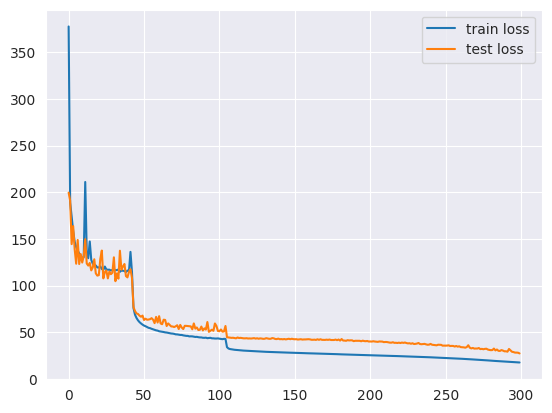

In [22]:
plot_losses(train_losses, test_losses)

In [23]:
train_acc, test_acc = calc_accuracy_mr(model, train_gen , test_gen, device = device, cnn= False)
print(f'Train accuracy for h11:{train_acc[0]:.4f}, Test accuracy for h11: {test_acc[0]:.4f}')
print(f'Train accuracy for h21:{train_acc[1]:.4f}, Test accuracy for h21: {test_acc[1]:.4f}')
print(f'Train accuracy for h31:{train_acc[2]:.4f}, Test accuracy for h31: {test_acc[2]:.4f}')
print(f'Train accuracy for h22:{train_acc[3]:.4f}, Test accuracy for h22: {test_acc[3]:.4f}')

Train accuracy for h11:0.4721, Test accuracy for h11: 0.4715
Train accuracy for h21:0.6062, Test accuracy for h21: 0.6039
Train accuracy for h31:0.2472, Test accuracy for h31: 0.2337
Train accuracy for h22:0.0889, Test accuracy for h22: 0.0848


In [24]:
torch.save(model, '/kaggle/working/saved_models/CNN_GRU_hybrid_cicy4_Hodge_v7.pt')